## 1. Introduction

## 2. Importing libraries

In [1]:
import os
import time
import itertools
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import binary_fill_holes

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

import joblib

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import seaborn as sns
import nibabel as nib

from skimage.exposure import equalize_adapthist
from skimage import morphology

# from sklearn import ...

## Read data

In [2]:
def read_nii(path):
    nii = nib.load(path)
    return nii, np.array(nii.get_fdata())


def read_subject(i, data_dir="./Dataset"): 
    root = os.path.join(data_dir, "Test" if i > 100 else "Train")
    pad_i = str(i).zfill(3)

    nii_ed, ed = read_nii(os.path.join(root, pad_i, pad_i + "_ED.nii"))
    nii_ed_seg, ed_seg = read_nii(os.path.join(root, pad_i, pad_i + "_ED_seg.nii"))
    nii_es, es = read_nii(os.path.join(root, pad_i, pad_i + "_ES.nii"))
    nii_es_seg, es_seg = read_nii(os.path.join(root, pad_i, pad_i + "_ES_seg.nii"))

    return np.stack((nii_ed, nii_ed_seg, nii_es, nii_es_seg)), np.stack((ed, ed_seg, es, es_seg))


def read_metadata(data_dir="./Dataset"):
    metadata_train = pd.read_csv(os.path.join(data_dir, "metaDataTrain.csv"))
    metadata_test = pd.read_csv(os.path.join(data_dir, "metaDataTest.csv"))

    return metadata_train, metadata_test

In [3]:
def voxel_volume(nii):
    return np.prod(nii.header.get_zooms())


def mri_height(nii):
    z = nii.header.get_zooms()[2]
    return z * nii.shape[2]

## Exploring data

### Images

In [4]:
def video(mri, seg=None):
    M, N, C = mri.shape
    
    fig, ax = plt.subplots()
    
    im = ax.imshow(mri[:, :, 0], cmap='gray', animated=True)
    
    if seg is not None:
        seg_overlay = np.zeros((M, N, 4))
        seg_im = ax.imshow(seg_overlay, animated=True)

    for frame in range(C):
        im.set_array(mri[:, :, frame])
        
        if seg is not None:
            seg_frame = seg[:, :, frame]
            overlay = np.zeros((M, N, 4))
            
            overlay[seg_frame == 1] = [1, 0, 0, 0.5]
            overlay[seg_frame == 2] = [0, 1, 0, 0.5]
            overlay[seg_frame == 3] = [0, 0, 1, 0.5]
            
            seg_im.set_array(overlay)
        
        clear_output(wait=True)
        display(fig)
        
        time.sleep(0.1)
        
    plt.close(fig)

In [5]:
nii, _ = read_nii("./Dataset/Train/001/001_ED.nii")
print(nii.header)
print(nii.affine)
print(voxel_volume(nii))
print(mri_height(nii))

_, mri = read_subject(1)
print()
print(f"shape: {mri.shape}")

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffse

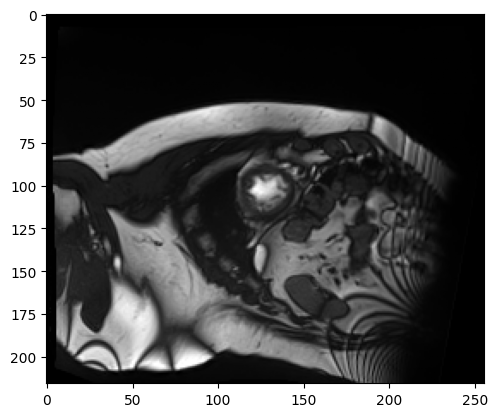

In [6]:
video(mri[0])

To maintain consistency we need to make sure that all images have the same shape.

In [7]:
shapes_ed = np.array([read_subject(i)[1][0].shape for i in range(1, 101)])

# Check if all rows are equal (shapes are the same)
print((shapes_ed == shapes_ed[0]).all())

print(shapes_ed[:, 0].min(), shapes_ed[:, 0].max())
print(shapes_ed[:, 1].min(), shapes_ed[:, 1].max())
print(shapes_ed[:, 2].min(), shapes_ed[:, 2].max())

False
154 428
154 512
6 18


We see that the shapes differ. For the first two dimensions, it is relatively easy to deal with: we can just interpolate and resize all images to have the same width and height. However, the difference in the third dimension is worrisome. We will deal with that later.

Let us see if this behaviour is the same for ES.

In [8]:
shapes_es = np.array([read_subject(i)[1][2].shape for i in range(1, 101)])

# Check if all rows are equal (shapes are the same)
print((shapes_es == shapes_es[0]).all())

print(shapes_es[:, 0].min(), shapes_es[:, 0].max())
print(shapes_es[:, 1].min(), shapes_es[:, 1].max())
print(shapes_es[:, 2].min(), shapes_es[:, 2].max())

False
154 428
154 512
6 18


The same shape mismatch is observed in ES. Can we at least have the same shapes for the same hearts in both ES and ED?

In [9]:
print((shapes_ed == shapes_es).all())

True


The data seems to be consistent for the same subjects. Let us check if the differences in dimensionality across subjects is common or is caused by outliers.

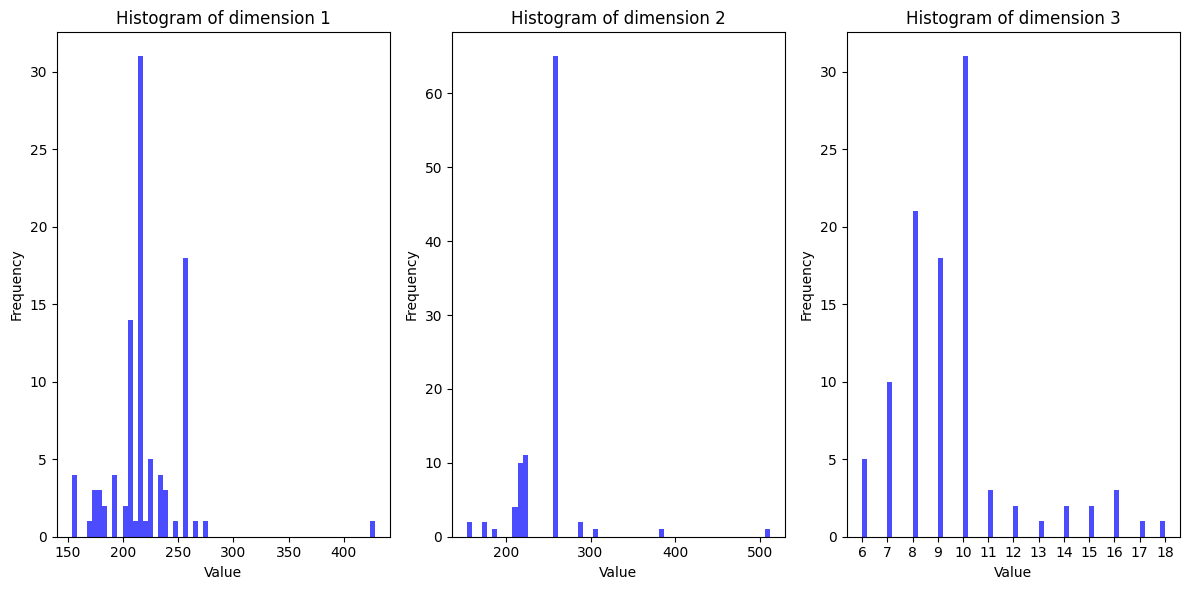

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

for i in range(3):
    ax[i].hist(shapes_ed[:, i], bins=60, alpha=0.7, color='blue')
    ax[i].set_title(f'Histogram of dimension {i+1}')
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')
    ax[i].grid(False)

    if i == 2:
        x_ticks = np.arange(int(np.min(shapes_ed[:, i])), int(np.max(shapes_ed[:, i])) + 1, 1)
        ax[i].set_xticks(x_ticks)

plt.tight_layout()
plt.show()

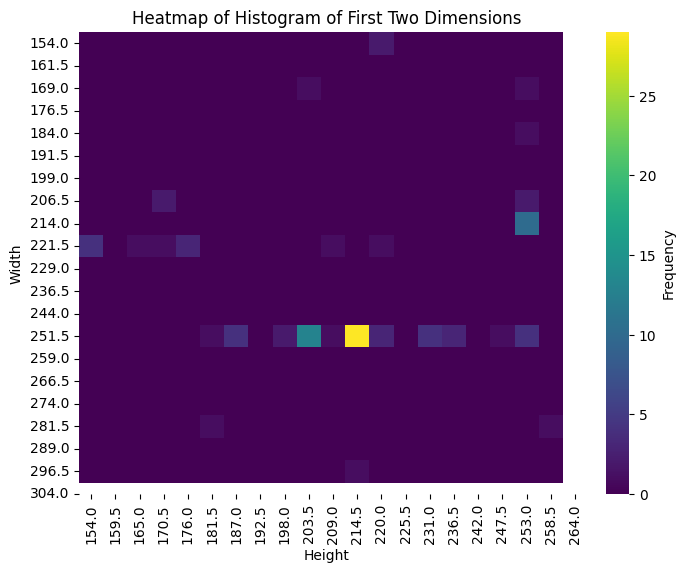

In [11]:
common_shapes = shapes_ed[(shapes_ed[:, 0] < 300) & (shapes_ed[:, 1] < 350)]

hist, xedges, yedges = np.histogram2d(common_shapes[:, 0], common_shapes[:, 1], bins=20)

plt.figure(figsize=(8, 6))
sns.heatmap(hist.T, cmap='viridis', cbar=True, 
            xticklabels=xedges, yticklabels=yedges, 
            cbar_kws={'label': 'Frequency'})

# Set labels and title
plt.xlabel('Height')
plt.ylabel('Width')
plt.title('Heatmap of Histogram of First Two Dimensions')
plt.show()

In [12]:
stats.mode(shapes_ed[:, :2])

ModeResult(mode=array([216, 256]), count=array([30, 65]))

We see that a great majority of data is $216 \times 256$. So, we can resize all other MRIs to this dimension. Regarding the number of slices per scan, we do not have a clear majority to simply discart the data that differs in shape.

Let us check where the LV segmentation is located in some samples.

In [13]:
N_samples = 6
idx = np.random.permutation(100)[:N_samples]
subjects = [read_subject(i)[1] for i in idx]

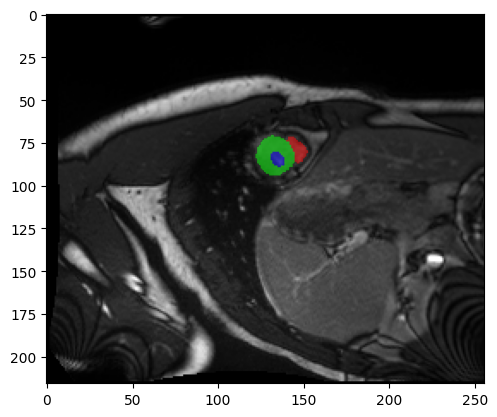

In [14]:
for ed, ed_seg, es, es_seg in subjects:
    video(ed, ed_seg)
    time.sleep(1)
    video(es, es_seg)
    time.sleep(1)

Let us check the voxel volume in the training data.

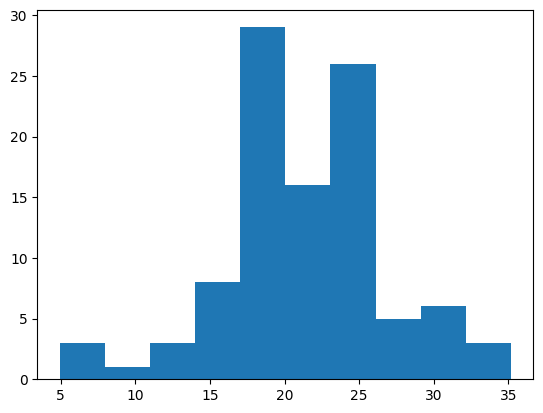

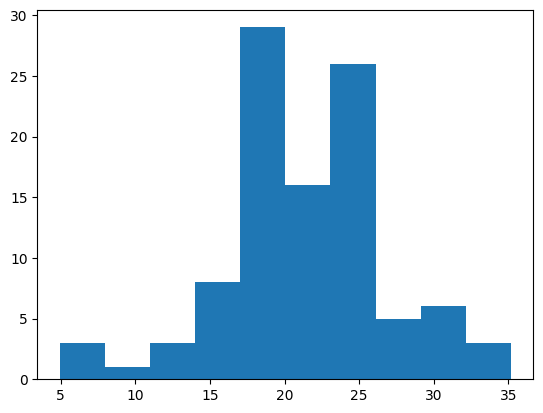

True


In [15]:
niis_ed = [read_subject(i)[0][0] for i in range(1, 101)]
niis_es = [read_subject(i)[0][2] for i in range(1, 101)]

vols_ed = np.array([voxel_volume(nii) for nii in niis_ed])
vols_es = np.array([voxel_volume(nii) for nii in niis_es])

plt.hist(vols_ed)
plt.show()

plt.hist(vols_es)
plt.show()

print((vols_ed == vols_es).all())

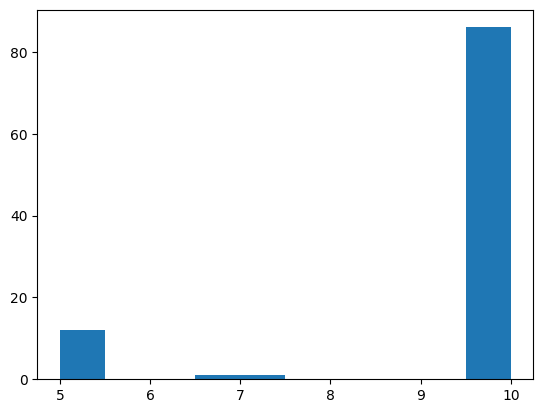

In [16]:
z = np.array([nii.header.get_zooms()[2] for nii in niis_ed])

plt.hist(z)
plt.show()

### Metadata

In [17]:
metadata_train, metadata_test = read_metadata()
metadata_train.head()

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


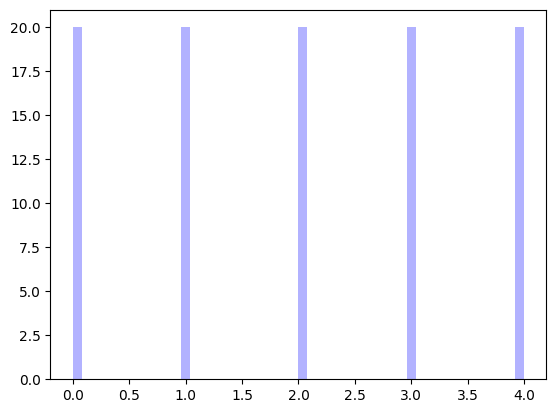

In [18]:
metadata_train["Category"].hist(bins=50, alpha=0.3, color='blue')
plt.grid(False)
plt.show()

We see that the data is well distributed across classes.

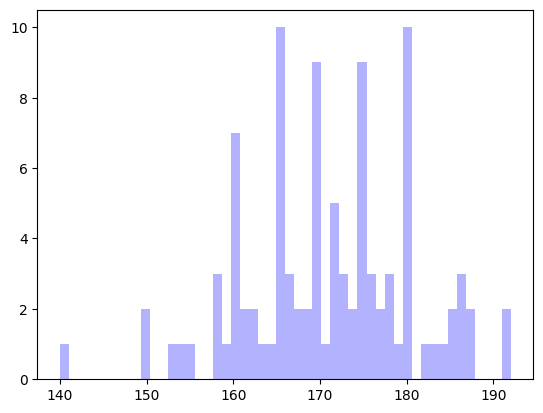

In [19]:
metadata_train["Height"].isna().any()

metadata_train["Height"].hist(bins=50, alpha=0.3, color='blue')
plt.grid(False)
plt.show()

It seems that all patients in the training data have heights. Let us check their weights.

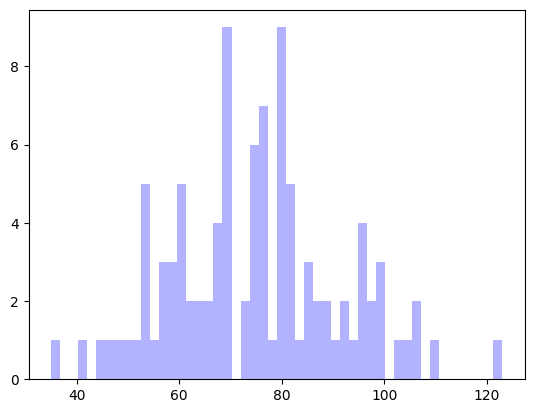

In [20]:
metadata_train["Weight"].isna().any()

metadata_train["Weight"].hist(bins=50, alpha=0.3, color='blue')
plt.grid(False)
plt.show()

Metadata seems ok for training set! Let's check the test metadata now.

In [21]:
metadata_test.head()

,Id,Height,Weight
0,101,170.0,70.0
1,102,162.0,60.0
2,103,185.0,104.0
3,104,158.0,56.0
4,105,164.0,64.0


False


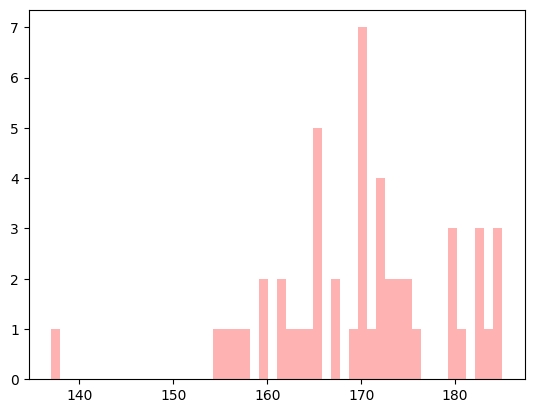

False


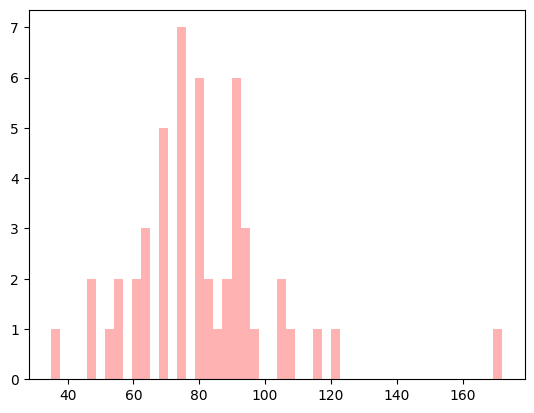

In [22]:
print(metadata_test["Height"].isna().any())

metadata_test["Height"].hist(bins=50, alpha=0.3, color='red')
plt.grid(False)
plt.show()

print(metadata_test["Weight"].isna().any())

metadata_test["Weight"].hist(bins=50, alpha=0.3, color='red')
plt.grid(False)
plt.show()

Great, we have all information about height and weight in the testing data as well.

## Strategy

Bernard et. al. \[2\] conducted an analysis on different strategies to tackle this segmentation and classification problem. For the segmentation of the different structures of the heart, we see different results in the table below. It is explained in the paper that the range of agreement is the size of a pixel. This means that the blue strategies differ from the best one (red) by at most 1 pixel.

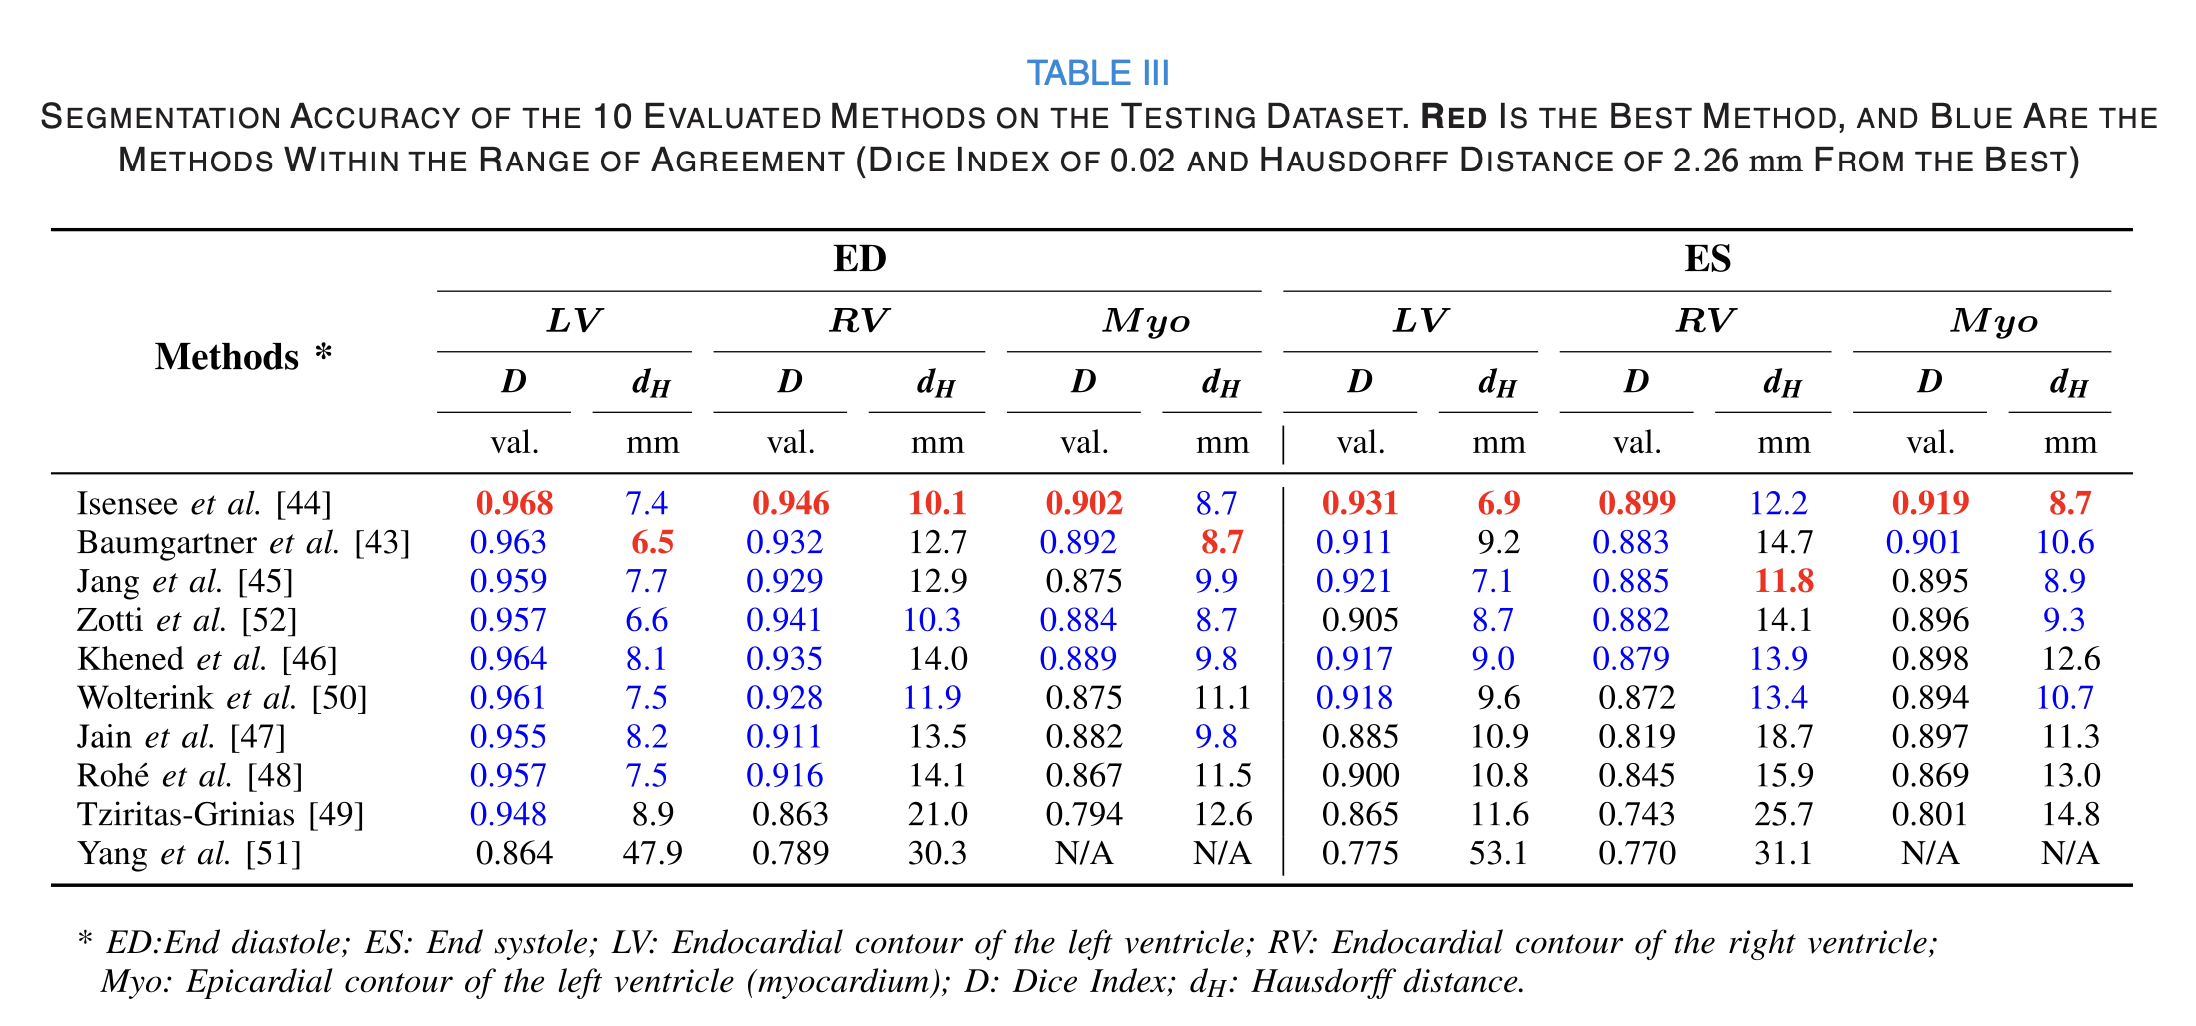

The table below shows the results of these strategies at identifying features based on the MRI images.

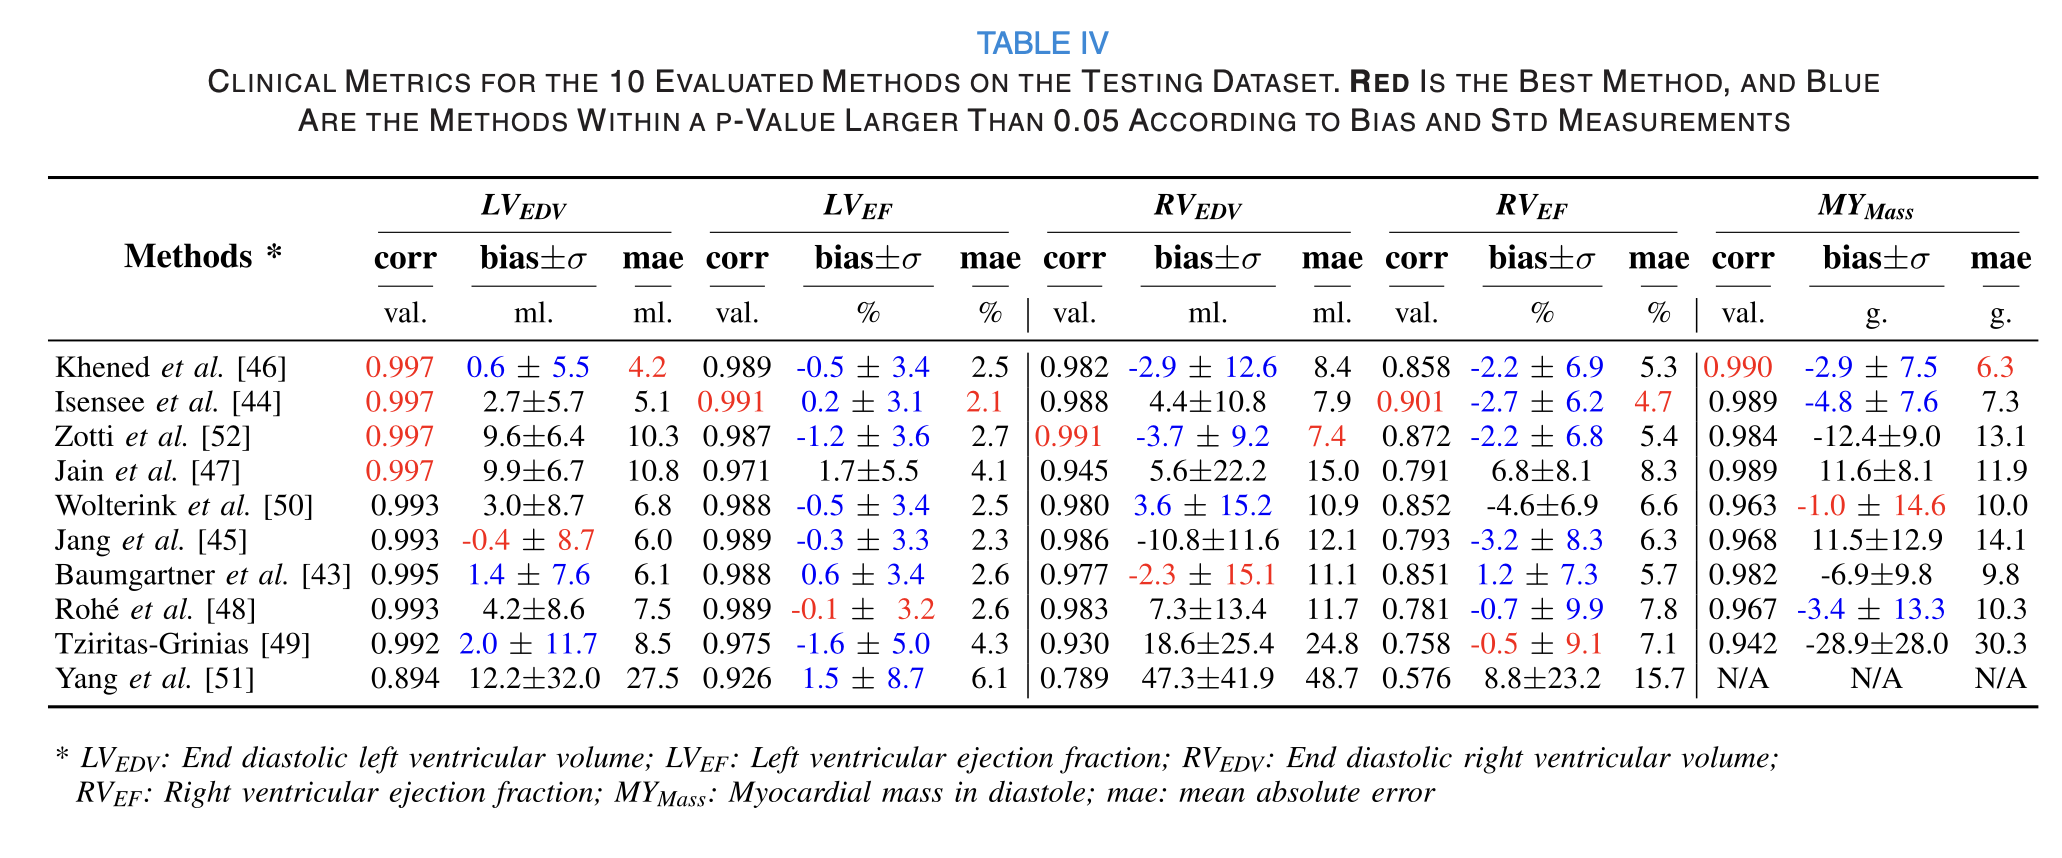

Finally, the table below shows the results in classification. The confusion matrix is from the strategy that winned the competition.

<center>
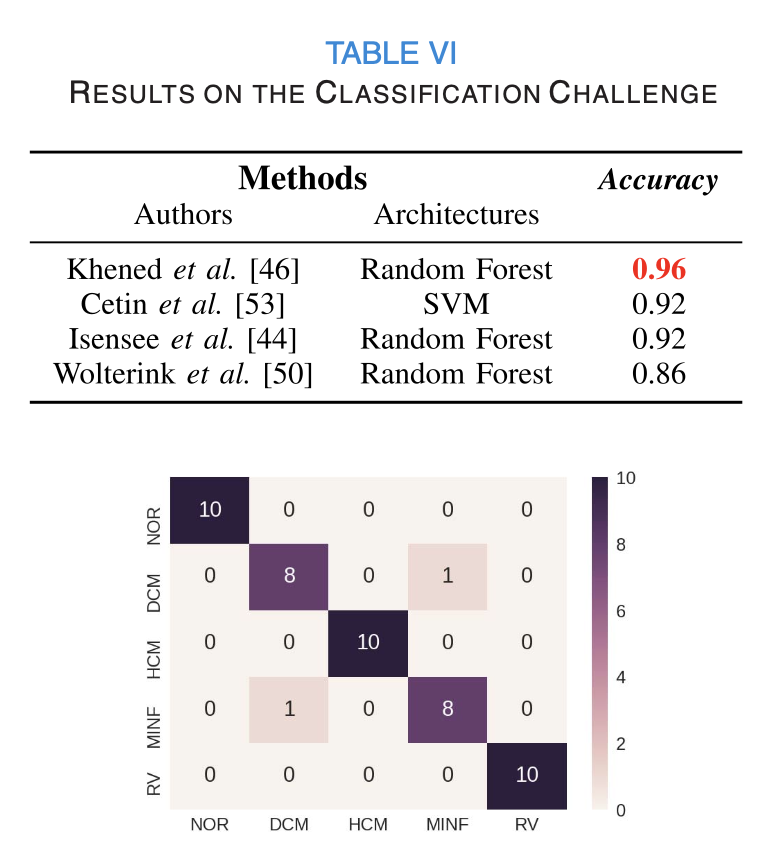
</center>

So, for segmentation, Isensee was the best strategy, while for feature extraction and classification, Khened is best.

However, there are some considerations to be made. Firstly, this project is most concerned with classification, and it is clear that Khened obtained a substantially better result in this aspect. Secondly, for the segmentation task, Isensee et al. \[3\] use a rather complicated model. Namely, they used a modified version of UNet 2D + UNet 3D and combined their outputs with a MLP to generate the output.
Lastly, focusing on the LV segmentation (which is what is important in this project), we see that the second best method is Khened. In fact, their dice score is very near the one from Isensee and the difference is at most 1 pixel.

Considering that segmentation is already given for RV and Myo, this 1 pixel difference would only matter between the LV and the background. Since it is very unlikely that the model misclassifies the background as LV, we can be pretty sure that Khened's method of LV segmentation has little to no difference in accuracy to the Isensee model.

From the data exploration did earlier, it seems like the LV cavity is always located "inside" the Myocardium segmentation. Treating every voxel inside the Myocardium as the LV seems like a naïve technique, but it might be worth testing.

We also have standalone models that try to segment the LV, like Margeta et. al. \[?\]. Finally, Zhen et. al. \[?\] proposes an algorithm to identify features without explicit segmentation. Thus, we face 4 main ways to extract features:
* Naïve LV segmentation
* Khened's DenseNet model to segment LV
* Margeta's Spatio-temporal Forests model to segment LV
* Zhen's algorithm for direct estimation

We are going to implement the three methods and compare their feature generation results using the training data. Then, the model considered best will be used to compute features.
Finally, given the success of Khened's RF, his architecture will be used for the classifier.

## LV Segmentation

In [23]:
# Helper functions

def dice(gt, seg, plot=False):
    union = np.sum(seg) + np.sum(gt)
    
    if union == 0:
        return 1

    if plot:
        plt.figure(figsize=(8, 8))
        
        plt.imshow(gt, cmap='Blues', alpha=0.5)
        plt.imshow(seg, cmap='Reds', alpha=0.5)
        
        legend_elements = [
            Patch(facecolor='blue', edgecolor='blue', label='Ground Truth'),
            Patch(facecolor='red', edgecolor='red', label='Segmentation')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.title("Ground Truth and Segmentation")
        plt.axis('off')
        plt.show()
        
    return 2 * np.sum(seg[gt == 1]) / (np.sum(seg) + np.sum(gt))

### Naïve LV segmentation

In [24]:
def naive_lv_seg(myo, closing=True):
    seg = np.zeros_like(myo)
    
    for i in range(seg.shape[2]):
        seg[..., i] = binary_fill_holes(myo[..., i]) ^ myo[..., i]

        radius = 2
        closed_myo = morphology.closing(myo[..., i], morphology.disk(radius))

        while closing and np.sum(seg[..., i]) == 0 and (myo[..., i] != closed_myo).any():
            seg[..., i] = binary_fill_holes(closed_myo) ^ closed_myo
            
            radius += 1
            closed_myo = morphology.closing(myo[..., i], morphology.disk(radius))

    return seg

In [25]:
subjects = [read_subject(i)[1] for i in range(1, 101)]

In [26]:
dices = []

for j, (ed, ed_seg, es, es_seg) in enumerate(subjects):
    ed_lv = naive_lv_seg(ed_seg == 2)
    es_lv = naive_lv_seg(es_seg == 2)

    for i in range(ed.shape[2]):
        dices.append(dice(ed_seg[..., i] == 3, ed_lv[..., i]))
        if dices[-1] != 1:
            print(j, i, dices[-1])
            
        dices.append(dice(es_seg[..., i] == 3, es_lv[..., i]))
        if dices[-1] != 1:
            print(j, dices[-1])

dices = np.array(dices)

10 0 0.9911025145067698
28 0 0.0
44 0.9889582333173308
67 0.97911227154047
68 0.9792207792207792
83 0.9929078014184397
95 0.997078870496592


In [27]:
print(f"Dice: {dices.mean():.3f} ± {dices.std():.3f}")

Dice: 0.999 ± 0.023


In [28]:
for j in [28, 44, 67, 68, 83, 95]:
    ed, ed_seg, es, es_seg = subjects[j]
    
    ed_lv = naive_lv_seg(ed_seg == 2)
    es_lv = naive_lv_seg(es_seg == 2)

    for i in range(ed.shape[2]):
        if dice(ed_seg[..., i] == 3, ed_lv[..., i], False) < 1:
            print("ED", j, i)
        if dice(es_seg[..., i] == 3, es_lv[..., i], False) < 1:
            print("ES", j, i)

ED 28 0
ES 44 0
ES 67 0
ES 68 0
ES 83 0
ES 95 1


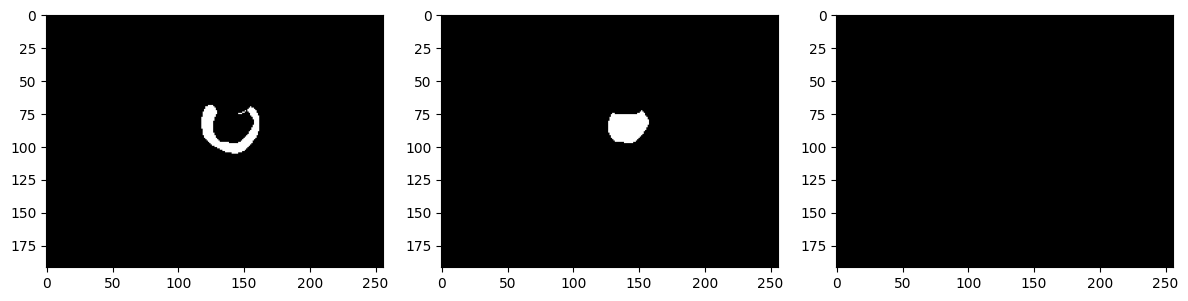

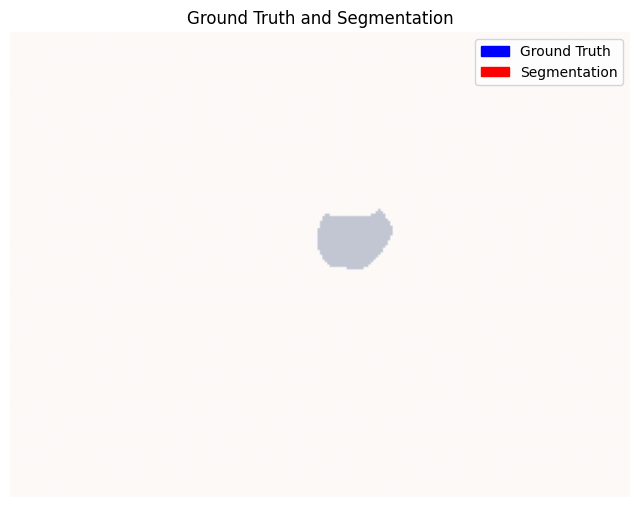

np.float64(0.0)

In [29]:
j = 28
i = 0

_, ed_seg, _, es_seg = subjects[j]
seg = naive_lv_seg(ed_seg == 2)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(ed_seg[..., i] == 2, cmap="gray")
ax[1].imshow(ed_seg[..., i] == 3, cmap="gray")
ax[2].imshow(seg[..., i], cmap="gray")

plt.tight_layout()
plt.show()

dice(ed_seg[..., i] == 3, seg[..., i], True)

## Feature extraction

Before extracting any features from the segmentation maps, we need to normalize the hearts. Most importantly, we need to make sure that each voxel in all images has the same physical volume. This way, we guarantee the consistency of our features for the training of the model.

In [30]:
def volume(seg, voxel_vol):
    return np.sum(seg) * voxel_vol


def ejection_fraction(edv, evs):
    return (edv - evs) / edv


def get_features(ed_seg, es_seg, nii):
    ed_rv = ed_seg == 1
    ed_myo = ed_seg == 2
    ed_lv = ed_seg == 3

    es_rv = es_seg == 1
    es_myo = es_seg == 2
    es_lv = es_seg == 3

    voxel_vol = voxel_volume(nii)
    
    edv_left = volume(ed_lv, voxel_vol)
    esv_left = volume(es_lv, voxel_vol)
    ef_left = ejection_fraction(edv_left, esv_left)

    edv_right = volume(ed_rv, voxel_vol)
    esv_right = volume(es_rv, voxel_vol)
    ef_right = ejection_fraction(edv_right, esv_right)

    myovd = volume(ed_myo, voxel_vol)
    myovs = volume(es_myo, voxel_vol)

    height = mri_height(nii)

    ed_ratio = edv_right / edv_left
    es_ratio = esv_left / esv_right

    myo_mass = myovd * 1.05 # Average heart density

    return ef_left, ef_right, edv_left, edv_right, myo_mass, ed_ratio, myovd / edv_left, esv_left - esv_right, es_ratio, height, esv_right / myovs

In [31]:
X = metadata_train[['Weight', 'Height']].to_numpy()
y = metadata_train[['Category']].to_numpy().ravel()

features = []

for i in range(1, 101):
    nii, mri = read_subject(i)

    ed_seg = mri[1]
    es_seg = mri[3]
    
    features.append(get_features(ed_seg, es_seg, nii[0]))

X = np.concatenate((X, features), axis=1)
print(X.shape)

(100, 13)


## Training model

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [33]:
class_names = ["Healthy", "HCM", "DCM", "MINF", "RVA"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, stratify=y, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=10, stratify=y_val, random_state=4)

In [34]:
rf = make_pipeline(StandardScaler(), RandomForestClassifier())
grid = {
    "randomforestclassifier__n_estimators": [50, 80, 100, 200, 300, 400],
    "randomforestclassifier__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]
}
scoring = {
    "accuracy": "accuracy",
    "f1": "f1_macro",
    "recall": "recall_macro"
}

model = GridSearchCV(estimator=rf, param_grid=grid, scoring="accuracy", cv=7)
model.fit(X_train, y_train)

print(f"Best acc: {model.best_score_}")
print(f"Best params: {model.best_params_}")

y_pred = model.predict(X_val)

Best acc: 0.9714285714285714
Best params: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 200}


[[4 0 0 0 0]
 [0 3 1 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   0.75 0.25 0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


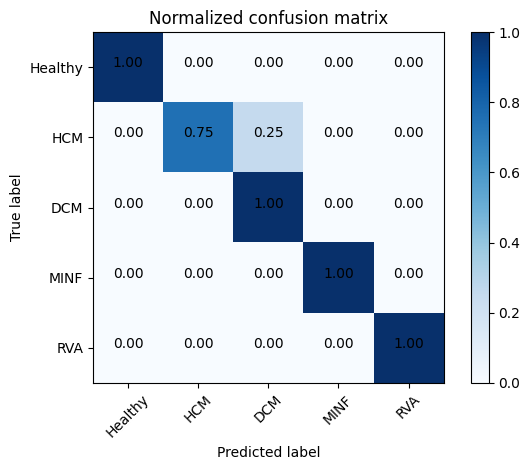

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



In [35]:
cnf_matrix = confusion_matrix(y_val, y_pred)
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(classification_report(y_val, y_pred))

In [42]:
joblib.dump(model, 'RF_2.pkl')

['RF_2.pkl']

## Predicting test data

In [37]:
X = metadata_test[['Weight', 'Height']].to_numpy()

features = []

for i in range(101, 151):
    nii, mri = read_subject(i)

    ed_seg = mri[1]
    es_seg = mri[3]

    ed_lv = naive_lv_seg(ed_seg == 2)
    es_lv = naive_lv_seg(es_seg == 2)
    ed_seg[ed_lv] = 3
    es_seg[es_lv] = 3
    
    features.append(get_features(ed_seg, es_seg, nii[0]))

X = np.concatenate((X, features), axis=1)
print(X.shape)

(50, 13)


In [44]:
y_probas = model.predict_proba(X)

In [67]:
np.sort(y_probas[:, 4])[-11:]
print(y_probas[30])

[0.38016474 0.00439553 0.00083333 0.09669368 0.51791272]


In [39]:
df = pd.DataFrame({
    'Id': np.arange(101, 151),
    'Category': y_final
})

In [40]:
df.to_csv("predict.csv", index=False)

(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. ]),
 <BarContainer object of 40 artists>)

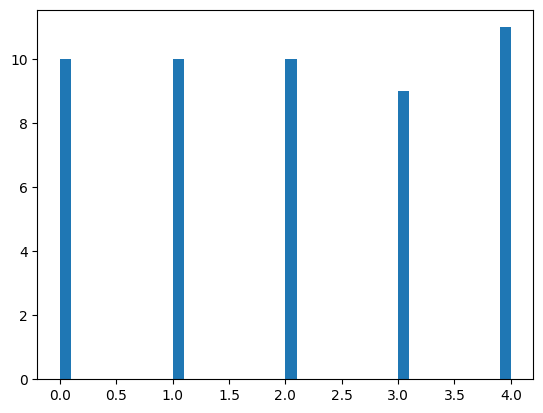

In [41]:
plt.hist(y_final, bins=40)

## References

\[1\] M. Khened, V. Alex, and G. Krishnamurthi, "Densely connected fully convolutional network for short-axis cardiac cine mr image segmentation and heart diagnosis using random forest," in *Statistical Atlases and Computational Models of the Heart. ACDC and MMWHS Challenges* (M. Pop, M. Sermesant, P.-M. Jodoin, A. Lalande, X. Zhuang, G. Yang, A. Young, and O. Bernard, eds.), (Cham), pp. 140–151, Springer International Publishing, 2018.

\[2\] O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, X. Yang, P.-A. Heng, I. Cetin, K. Lekadir, O. Camara, M. A. Gonzalez Ballester, G. Sanroma, S. Napel, S. Petersen, G. Tziritas, E. Grinias, M. Khened, V. A. Kollerathu, G. Krishnamurthi, M.-M. Rohé, X. Pennec, M. Sermesant, F. Isensee, P. Jäger, K. H. Maier-Hein, P. M. Full, I. Wolf, S. Engelhardt, C. F. Baumgartner, L. M. Koch, J. M. Wolterink, I. Išgum, Y. Jang, Y. Hong, J. Patravali, S. Jain, O. Humbert, and P.-M. Jodoin, "Deep learning techniques for automatic mri cardiac multi-structures segmentation and diagnosis: Is the problem solved?," *IEEE Transactions on Medical Imaging*, vol. 37, no. 11, pp. 2514–2525, 2018.

\[3\] F. Isensee, P. F. Jaeger, P. M. Full, I. Wolf, S. Engelhardt, and K. H. Maier-Hein, "Automatic cardiac disease assessment on cine-mri via time-series segmentation and domain specific features," in *Statistical Atlases and Computational Models of the Heart. ACDC and MMWHS Challenges* (M. Pop, M. Sermesant, P.-M. Jodoin, A. Lalande, X. Zhuang, G. Yang, A. Young, and O. Bernard, eds.), (Cham), pp. 120–129, Springer International Publishing, 2018.
